# Convolutions and CNNs

**Level.** Low. Math and concepts of convolutions and neural networks using them using PyTorch and image visualizations, building up to residual networks.

As usual, these notes are a rehashing of the textbook. In this case, it's mostly [Chapter 13](https://github.com/fastai/fastbook/blob/master/13_convolutions.ipynb) with a bit of [Chapter 4](https://github.com/fastai/fastbook/blob/master/04_mnist_basics.ipynb).

## Sections in this Notebook

1. [Dense Networks for Images](#scrollTo=7XFN8f9tqUP7)
2. [What's a Convolution?](#scrollTo=zZNPNW51EyB-)
3. [Image Convolutions](#scrollTo=4J6meoGHUghk)
3. A Convolutional Neural Network
4. Deep CNNs and Resnets


## Vocab Terms

* **CNN.** Short for convolutional neural network. Mostly used for image analysis, but can be used for anything requiring preservation of spatial (or positional) information.

* **convolution.** A mathematical operation combining two tensors to produce a new one. We will generally be convolving an image with a filter in our networks.

* **dense network.** A network where every node in a layer connects with every node in the previous (or next) layer. This is how we built our network much earlier in the course.

* **filter.** A small tensor whose elements are convolved with a signal or image to transform it to extract some information. A gaussian filter leads to a blurring of an image, which you've probably seen before.

* **ResNet.** A residual network. A residuals is an input to a particular layer which skip over intervening layers and instead uses the original, unprocessed data. These are used for regularization and to improve  training in deep networks.

## Dense Networks for Images

The neural networks we built earlier in the course were what are called **dense networks**: every node in each layer of the network is connected to every other node in the previous (and next) layer. For images, this quickly leads to two problems:

1. Large number of model parameters
2. Loss of spatial information

EX: Analyzing a game of tic tac toe with a dense neural network

* You could have pictures of different games as inputs, which converted to a table could have 9 columns (Upperright,upperleft,uppermiddle,etc) representing each space on the board, with the entries being whats in that spot and what isnt (X,O, or blank)... This converts an image into a table

* * From here you could have 1 node for each column, which contribute to some N number of hidden nodes across L hidden layers to get an output of either X wins, O wins, or its a draw

- There are limitations to this method however... a network would have to learn that in tic tac toe you care about only certain squares (the ones that help you win, and prevent the other from winning)

- - So it needs to understand the spatial structure of the tic tac toe board, which turning this into a table wouldn't directly accomplish

Limitations:

1) Parameter Scaling - How the parameters scale
*  EX: If i have 9 inputs and the next layer has N nodes, it'd need 9N parameters to connect

2) Network must learn spatial relationships


#### **Parameter Scaling.**

The first is easy to explain: let's say we've got a 256$\times$256 pixel color image. For a single image, that's about 200,000 variables in the input! If the next layer is 200 neurons, then we've already got over 40 million parameters. It's going to be way too easy to overfit.

#### **Spatial Information.**

Colors of pixels in images aren't randomly distributed, but clustered together. In a photo of a red car driving along the highway, there will be some red (the car), with some blue over it (if you're lucky the sky's blue), and black (road) and green (grass) below it.

If we saw the colors shuffled around, with the blue on the bottom, it would be a boat on a river instead. By taking every pixel value as a direct input to a bunch of nodes dense neural network, we lose that spatial information.

In *theory* this isn't a problem, because the network should just learn that nearby pixels should share more information than pixels that are far away.

Convolutional neural networks mostly solve both of these problems. But first, we need to learn what convolutions are.

## Convolutions

Convolution is a process where a tensor containing some data is combined with a filter to smooth or otherwise extract features from the data. The most important part is that the filter acts locally on the data, meaning that spatial information about nearby pixels or points is maintained.

Let's look at an example from 1D signal processing. Here, the data is called a "signal" and the filters are often called "window functions" Your instructor's Ph.D. is in signal processing these kinds of 1D radio signals. Below is a sine wave with some added noise. It looks (unsurprisingly) very noisy.

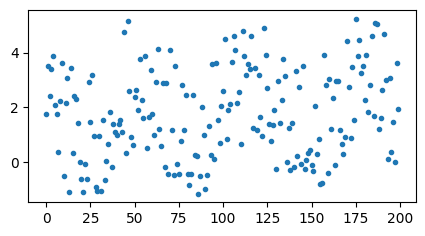

In [ ]:
# Don't worry about the code here
# or in the following cells, until we go to build a CNN.
import numpy as np
import matplotlib.pyplot as plt

# Randomly generate some data
x = np.arange(-10, 10, 0.1)
y = np.random.random(200)*5 + np.sin(x) - 0.5

plt.figure(figsize=(5,2.5))
plt.plot(y, '.')
plt.show()

#So right now we have a sin function here, but the data is extremely noisy

We can create the following filter, convolve it with the original set of data, and plot them both together. You can see that the orange line is much smoother than the original blue points.

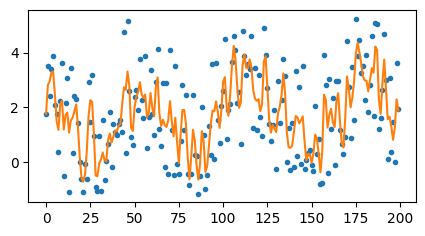

In [ ]:
filter = [0.1]*10

#filter = [0.25,0.5,0.25]

plt.figure(figsize=(5,2.5))
plt.plot(y, '.')
plt.plot(np.convolve(y, filter, mode="same"), '-')
plt.show()

In [ ]:
filter #This is all just 0.1s

#What it does is average 10 points in a row

#Essentially, convultion is extracting data out of spatial information

[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]

#### **How Convolutions are Calculated.**

This explanation is not nearly as useful as what I'm going to draw on the board in class, but here's a try.

One-dimensional convolutions are a good starting point. Here's some sample data, and a filter:

In [ ]:
data = [1,2,1,0,3,2,1]
filter = [0.25, 0.5, 0.25]

#The out put comes from the center of the filter, so we do

#  1      2      1
#  *      *      *
#  0.25   0.5    0.25

#Then adding all these together, getting 1.5

#We repeat this a step down, doing

#  2      1      0
#  *      *      *
#  0.25   0.5    0.25

#and get 1.5

#We repeat and repeat and repeat, moving the figure across the data

#Then this output layer gets saved


#Filter examples

#0.25 0.5 0.25 ---> Smoothing the average (Hamming filter - good for frequency analysis)
#0.1 0.8 0.1 ----> Smoothing the average (Hamming filter - good for frequency analysis)
#0 1 0 ------> Does nothing essentially (Identity)
#0 1 -1 ----> edge detector
#0.33 0.33 0.33 ---- Regular average
#-1 3 -1 ---> Sharpens the data

We imagine matching up the filter and the data one entry at a time. The data is bigger than the filter, but that's fine. We'll be sliding the filter along to calculate the output (for *math definition reasons* we actually flip the order of the filter first).

|index|0|1|2|3|4|5|6|
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|data|1|2|1|0|3|2|1|
|filter|0.25|0.5|0.25|

To get the output, we multiply the matched up entries in the data and the filter, then add them together, so the first entry of the output is:

$$z_0 = x_0 f_2 + x_1 f_1 + x_2 f_0 = 1(0.25) + 2(0.5) + 1(0.25) = 1.5$$

Then, we slide the filter one space to find the next entry in the output:

|index|0|1|2|3|4|5|6|
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|data|1|2|1|0|3|2|1|
|filter||0.25|0.5|0.25|

and calculate:
$$z_1 = 2(0.25) + 1(0.5) + 0(0.25) = 1$$

and so on, until we get that the output is:

|index|0|1|2|3|4|
|:-:|:-:|:-:|:-:|:-:|:-:|
|$z$|1.5|1|1|2|2|

In [ ]:
z = np.convolve(data, filter, mode="valid") #There is a function for this
z

array([1.5, 1. , 1. , 2. , 2. ])

The result of the convolution is *smaller* than the input, which is a bit weird if we're trying to compare what the output looks like to the input. Traditionally, this is fixed by padding the edges of the data with 0s until you get a result that's the same size as the original:

|source||||||||||
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|data|"0"|1|2|1|0|3|2|1|"0"|
|filter|0.25|0.5|0.25|
|$z$||1|1.5|1|1|2|2|1|

Note that the central values are unchanged from the unpadded version.

with numpy:

Note: "0" is air quotes, as in imaginary, since if we slide a filter over it wont change the output too much, its not a string

- While this may drag your filter closer to 0, you will get an output which is the same size, so they can be overlayed on eachother

In [ ]:
z = np.convolve(data, filter, mode="same")
z

array([1. , 1.5, 1. , 1. , 2. , 2. , 1. ])

We can see that the output of this filtering "smoothed" the input data: the 2 and the 3 are now smaller, and the 0 is now larger, with everything moving toward the mean. How did this happen? If we look at the filter, `[0.25, 0.5, 0.25]`, and think about the calculation of one particular entry in the output:

|source||||||||||
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|data|"0"|1|2|1|0|3|2|1|"0"|
|filter||||0.25|0.5|0.25|
|$z$|  ||   | |1   ||||

That entry is $0.5\times$ the same entry in the data plus $0.25\times$ the adjacent entries. So it actually averages the 3 points together, with a bit more weight given to that particular entry. If we wanted a perfect average of all 3, we're make our filter `[0.333, 0.333, 0.333]`.

#### **The Power of Filters.**

Taking averages isn't the only thing a filter can do! Consider this filter `[-1, 3, -1]` applied to our dataset. It exaggerates all of the peaks, increasing the 2 to a 4, the 3 to a 7, and makes that 0 negative.

|source||||||||||
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|data|"0"|1|2|1|0|3|2|1|"0"|
|$z$|  |1|4|1|-4|7|2|1|

In [ ]:
unsharp = [-1, 3, -1]
np.convolve(data, unsharp, mode="same")

array([ 1,  4,  1, -4,  7,  2,  1])

And here's an edge detector filter, `[0,-1,1]`, which is positive if the next value is larger, and negative if the next value is smaller (remember the flipping of the filter order? Me neither. It took me 20 minutes to figure out what was wrong with my filter).

|source||||||||||
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|data|"0"|1|2|1|0|3|2|1|"0"|
|$z$|  |1|-1|-1|3|-1|-1|-1|

In [ ]:
edges = [1, -1, 0]
np.convolve(data, edges, mode="same")

array([ 1, -1, -1,  3, -1, -1, -1])

To summarize, convolutions:
* Preserve local information in an image.
* Can be used to smooth (or "blur"), sharpen, or find edges, among other things.

Now, let's apply convolutions to images.

## Image Convolutions

We'll start simple, by looking at some small black and white images from the MNIST number dataset. This is a collection of handwritten numbers which are $28\times28$ images.

In [ ]:
# Don't worry about the code here
# or in the following cells, until we go to build a CNN.

from fastai.vision.all import *
from scipy.signal import convolve2d
from PIL import Image as im
matplotlib.rc('image', cmap='Greys')

path = untar_data(URLs.MNIST_SAMPLE)
im3 = Image.open(path/'train'/'3'/'12.png')

Here's a 3 from the dataset:

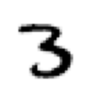

In [ ]:
show_image(im3);

We can convert the image to a numpy array and take a look at how it's stored. The values in the image are 0 (white) to 255 (black), although the visualizer automatically adjusts the color scale based on the range of the data.

There's no color, but if there were, there would just be a third dimension for the red, green, and blue color information.

In [ ]:
np.array(im3)[10:20,10:20]

array([[  0,   0,   6, 152, 246, 254, 254,  49,   0,   0],
       [  0,  66, 158, 254, 254, 249, 103,   8,   0,   0],
       [ 54, 251, 254, 254, 254, 248,  74,   5,   0,   0],
       [140, 254, 254, 254, 254, 254, 254, 202, 125,  45],
       [ 58, 181, 234, 254, 254, 254, 254, 254, 254, 252],
       [  0,   0,  30,  50,  73, 155, 253, 254, 254, 254],
       [  0,   0,   0,   0,   0,   0,  91, 200, 254, 254],
       [  0,   0,   0,   0,   0,   0,   0,   4, 192, 254],
       [  0,   0,   0,   0,   0,   0,   0,   0, 141, 254],
       [ 86,   0,   0,   0,   0,   0,   0,   3, 188, 254]], dtype=uint8)

Now, let's create some filters. Since the image is 2 dimensions, we need a 2 dimensional filter.

We'll create a blurring filter, an unsharp mask, and an edge detector, just like we did for the 1D signals:

<Axes: >

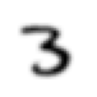

In [ ]:
blur = np.array([[0.111, 0.111, 0.111],
                 [0.111, 0.111, 0.111],
                 [0.111, 0.111, 0.111]])

show_image( convolve2d(np.array(im3), blur) )

<Axes: >

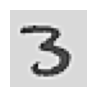

In [ ]:
unsharp = np.array([[-0.125, -0.125, -0.125],
                    [-0.125,  2.000, -0.125],
                    [-0.125, -0.125, -0.125]])

show_image( convolve2d(np.array(im3), unsharp) )

<Axes: >

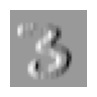

In [ ]:
edge = np.array([[-1, 1.0, 0],
                 [-1, 1.0, 0],
                 [-1, 1.0, 0]])

show_image( convolve2d(np.array(im3), edge) )